# Imports

In [1]:
import pandas as pd
import QuantLib as ql
from datetime import datetime
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm
import statsmodels.api as sm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Load data

In [2]:
data = pd.read_parquet('/Users/vittoriomanfriani/Desktop/bond_data_auction.parquet')
# take data only from 2010-01-01
data = data.loc[data.index.get_level_values(0) >= '2010-01-01']
data

dv01  coupon   maturity       price     yield  \
timestamp  id                                                             
2010-01-01 US912810DP04  5.878  11.250 2015-02-15  141.125000  2.607000   
           US912810DS43  6.362  10.625 2015-08-15  140.546875  2.774000   
           US912810DT26  6.506   9.875 2015-11-15  137.468750  2.881000   
           US912810DV71  6.656   9.250 2016-02-15  134.796875  2.981000   
           US912810DW54  6.521   7.250 2016-05-15  123.875000  3.087000   
...                        ...     ...        ...         ...       ...   
2024-11-01 US912828Y958  1.618   1.875 2026-07-31   96.083984  5.992257   
2024-11-04 US912828Y958  1.617   1.875 2026-07-31   96.156250  6.004602   
2024-11-05 US912828Y958  1.614   1.875 2026-07-31   96.128906  6.019502   
2024-11-06 US912828Y958  1.609   1.875 2026-07-31   96.013672  6.036694   
2024-11-07 US912828Y958    NaN   1.875 2026-07-31   96.109375  6.048938   

                        first_datapoint  time to maturity record_date  \
timestamp  id                                                           
2010-01-01 US912810DP04      1990-01-03          5.122519  1985-05-15   
           US912810DS43      1990-01-03          5.618070  1985-08-15   
           US912810DT26      1990-01-03          5.869952  1985-11-29   
           US912810DV71      1990-01-03          6.121834  1986-02-18   
           US912810DW54      1990-01-03          6.368241  1986-08-15   
...                                 ...               ...         ...   
2024-11-01 US912828Y958      2019-07-26          1.744011  2019-07-31   
2024-11-04 US912828Y958      2019-07-26          1.735797  2019-07-31   
2024-11-05 US912828Y958      2019-07-26          1.733060  2019-07-31   
2024-11-06 US912828Y958      2019-07-26          1.730322  2019-07-31   
2024-11-07 US912828Y958      2019-07-26          1.727584  2019-07-31   

                             cusip security_type  ... treas_retail_accepted  \
timestamp  id                                     ...                         
2010-01-01 US912810DP04  912810DP0          Bond  ...                  None   
           US912810DS43  912810DS4          Bond  ...                  None   
           US912810DT26  912810DT2          Bond  ...                  None   
           US912810DV71  912810DV7          Bond  ...                  None   
           US912810DW54  912810DW5          Bond  ...                  None   
...                            ...           ...  ...                   ...   
2024-11-01 US912828Y958  912828Y95          Note  ...              13057700   
2024-11-04 US912828Y958  912828Y95          Note  ...              13057700   
2024-11-05 US912828Y958  912828Y95          Note  ...              13057700   
2024-11-06 US912828Y958  912828Y95          Note  ...              13057700   
2024-11-07 US912828Y958  912828Y95          Note  ...              13057700   

                        treas_retail_tenders_accepted  \
timestamp  id                                           
2010-01-01 US912810DP04                          None   
           US912810DS43                          None   
           US912810DT26                          None   
           US912810DV71                          None   
           US912810DW54                          None   
...                                               ...   
2024-11-01 US912828Y958                           Yes   
2024-11-04 US912828Y958                           Yes   
2024-11-05 US912828Y958                           Yes   
2024-11-06 US912828Y958                           Yes   
2024-11-07 US912828Y958                           Yes   

                        unadj_accrued_int_per1000  unadj_price  \
timestamp  id                                                    
2010-01-01 US912810DP04                      None         None   
           US912810DS43                      None         None   
           US912810DT26                      None         None   


In [3]:
data = data[['coupon', 'maturity', 'yield', 'price','time to maturity', 'issue_date']]
# Prepare the dataset
data = data.rename(columns={
    "maturity": "maturity_date"
})

In [4]:
data

coupon maturity_date     yield       price  \
timestamp  id                                                         
2010-01-01 US912810DP04  11.250    2015-02-15  2.607000  141.125000   
           US912810DS43  10.625    2015-08-15  2.774000  140.546875   
           US912810DT26   9.875    2015-11-15  2.881000  137.468750   
           US912810DV71   9.250    2016-02-15  2.981000  134.796875   
           US912810DW54   7.250    2016-05-15  3.087000  123.875000   
...                         ...           ...       ...         ...   
2024-11-01 US912828Y958   1.875    2026-07-31  5.992257   96.083984   
2024-11-04 US912828Y958   1.875    2026-07-31  6.004602   96.156250   
2024-11-05 US912828Y958   1.875    2026-07-31  6.019502   96.128906   
2024-11-06 US912828Y958   1.875    2026-07-31  6.036694   96.013672   
2024-11-07 US912828Y958   1.875    2026-07-31  6.048938   96.109375   

                         time to maturity issue_date  
timestamp  id                                         
2010-01-01 US912810DP04          5.122519 1985-05-15  
           US912810DS43          5.618070 1985-08-15  
           US912810DT26          5.869952 1985-11-29  
           US912810DV71          6.121834 1986-02-18  
           US912810DW54          6.368241 1986-08-15  
...                                   ...        ...  
2024-11-01 US912828Y958          1.744011 2019-07-31  
2024-11-04 US912828Y958          1.735797 2019-07-31  
2024-11-05 US912828Y958          1.733060 2019-07-31  
2024-11-06 US912828Y958          1.730322 2019-07-31  
2024-11-07 US912828Y958          1.727584 2019-07-31  

[1132542 rows x 6 columns]

In [5]:
def filter_bonds_by_intervals(df, max_years=30):

    filtered_bonds = []  # List to store the selected bonds

    # Iterate over each yearly interval (e.g., 0-1, 1-2, ..., 29-30)
    for year in range(max_years):
        lower_bound = year
        upper_bound = year + 1

        # Filter bonds in the current time-to-maturity interval
        interval_bonds = df[(df['time to maturity'] > lower_bound) & (df['time to maturity'] <= upper_bound)]

        if not interval_bonds.empty:
            # Sort bonds by issue_date in descending order and select the latest issued bond
            latest_bond = interval_bonds.sort_values(by='issue_date', ascending=False).iloc[0]
            filtered_bonds.append(latest_bond)

    # Combine the selected bonds into a single DataFrame
    result_df = pd.DataFrame(filtered_bonds)

    return result_df

In [8]:
OTR = filter_bonds_by_intervals(data.loc['2010-01-01'])

In [9]:
OTR

,coupon,maturity_date,yield,price,time to maturity,issue_date
US912828JV34,0.875,2010-12-31,0.479,100.390625,0.996578,2008-12-31
US912828ML15,1.000,2011-12-31,1.139,99.726562,1.995893,2009-12-31
US912828MB33,1.125,2012-12-15,1.674,98.429688,2.954141,2009-12-15
US912828JW17,1.500,2013-12-31,2.189,97.382812,3.997262,2008-12-31
US912828ME71,2.625,2014-12-31,2.681,99.742188,4.996578,2009-12-31
US912828DM98,4.000,2015-02-15,2.668,106.328125,5.122519,2008-10-15
US912828MD98,3.250,2016-12-31,3.385,99.164062,6.997947,2009-12-31
US912828HH67,4.250,2017-11-15,3.538,104.843750,7.871321,2007-12-17
US912828JR22,3.750,2018-11-15,3.745,100.031250,8.870637,2009-01-15
US912828LY45,3.375,2019-11-15,3.837,96.234375,9.869952,2009-11-11


# Spot Rates Calculation

In [4]:
def pydatetime_to_quantlib_date(py_datetime: datetime) -> ql.Date:
    return ql.Date(py_datetime.day, py_datetime.month, py_datetime.year)


def quantlib_date_to_pydatetime(ql_date: ql.Date):
    return datetime(ql_date.year(), ql_date.month(), ql_date.dayOfMonth())


In [5]:
def get_spot_rates(yieldcurve, day_count,
                   calendar=ql.UnitedStates(ql.UnitedStates.GovernmentBond), months=361):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    for month in range(0, months):
        yrs = month / 12.0
        d = calendar.advance(ref_date, ql.Period(month, ql.Months))
        compounding = ql.Compounded
        freq = ql.Semiannual

        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        eq_rate = zero_rate.equivalentRate(
                day_count, compounding, freq, ref_date, d
            ).rate()
        tenors.append(yrs)
        spots.append(100 * eq_rate)

    return pd.DataFrame(list(zip(tenors, spots)),
                        columns=["Maturities", "Curve"],
                        index=[''] * len(tenors))

In [6]:
def get_spot_rates_on_tenors(yieldcurve, day_count):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    dates = yieldcurve.dates()
    for i, d in enumerate(dates):
        yrs = day_count.yearFraction(ref_date, d)
        compounding = ql.Compounded
        freq = ql.Semiannual

        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        eq_rate = zero_rate.equivalentRate(day_count, compounding, freq, ref_date, d).rate()
        tenors.append(yrs)
        spots.append(100 * eq_rate)

    return pd.DataFrame(list(zip(tenors, spots)),
                        columns=["Maturities", "Curve"],
                        index=[''] * len(tenors))


# Spot Rates Bootstrapper

In [7]:
# function to construct yield curve
def get_spot_rates_bootstrapper(curve_set_df: pd.DataFrame, current_date: datetime, tenors = True, rolldown = False):
    calendar = ql.UnitedStates(m=ql.UnitedStates.GovernmentBond)
    current_date = calendar.adjust(pydatetime_to_quantlib_date(py_datetime=current_date))
    ql.Settings.instance().evaluationDate = current_date

    t_plus = 1
    bond_settlement_date = calendar.advance(current_date, ql.Period(t_plus, ql.Days))
    frequency = ql.Semiannual
    day_count = ql.ActualActual(ql.ActualActual.ISDA)
    par = 100.0

    bond_helpers = []
    seen_maturities = set()

    # Iterate over the dataset
    for _, row in curve_set_df.iterrows():
        maturity = pydatetime_to_quantlib_date(row["maturity_date"])

        # Skip duplicate maturities
        if maturity in seen_maturities:
            continue

        seen_maturities.add(maturity)

        schedule = ql.Schedule(
            bond_settlement_date,
            maturity,
            ql.Period(frequency),
            calendar,
            ql.ModifiedFollowing,
            ql.ModifiedFollowing,
            ql.DateGeneration.Backward,
            False,
        )
        helper = ql.FixedRateBondHelper(
            ql.QuoteHandle(ql.SimpleQuote(row['price'])),
            t_plus,
            100.0,
            schedule,
            [row["coupon"] / 100],
            day_count,
            ql.ModifiedFollowing,
            par,
        )
        bond_helpers.append(helper)

    yc = ql.PiecewiseCubicZero(current_date, bond_helpers, day_count)
    yc.enableExtrapolation()

    # Get spot rates
    if tenors:
        splcd = get_spot_rates_on_tenors(yc, day_count)
    else:
        splcd = get_spot_rates(yc, day_count)

    if rolldown == False:
        return splcd

    if rolldown == True:
        return yc

# Apply Bootstrapper Function to Dataset

In [8]:
# Get on the run bonds
def OTR(df):
    # filter for maturities too short
    df = df.loc[df['time to maturity'] > 0.02].copy()

    # filter dataset to keep only OTR bonds
    df_reset = df.reset_index()

    df_reset['issue_date'] = pd.to_datetime(df_reset['issue_date'])
    df_reset['maturity_date'] = pd.to_datetime(df_reset['maturity_date'])

    on_the_run_bonds = df_reset.loc[df_reset.groupby(['timestamp', 'maturity_date'])['issue_date'].idxmax()]

    on_the_run_bonds = on_the_run_bonds.set_index(['timestamp', 'id'])

    return on_the_run_bonds

on_the_run_bonds = OTR(data)

In [9]:
def apply_bootstrapper(df, tenors = True):
    # Create an empty list to store data
    results_list = []

    # Iterate through each date in the dataset
    for date in tqdm(on_the_run_bonds.index.get_level_values(0).unique()):
        curve_set_df = on_the_run_bonds.loc[date]

        zero_rate_curve = get_spot_rates_bootstrapper(curve_set_df, date, tenors)

        # Add the date as a new column
        zero_rate_curve['Date'] = date

        # Append the DataFrame to the list
        results_list.append(zero_rate_curve)

    # Concatenate all the results
    final_df = pd.concat(results_list)
    final_df.set_index(['Date'], inplace=True)

    return final_df

## Apply function to dataset

In [10]:
# Filter out too small maturities
zero_curve_df = apply_bootstrapper(on_the_run_bonds, tenors=False)

100%|██████████| 3873/3873 [02:06<00:00, 30.73it/s]


In [11]:
zero_curve_df.head()

,Maturities,Curve
Date,,
2010-01-01,0.000000,0.000000
2010-01-01,0.083333,-0.143283
2010-01-01,0.166667,-0.078591
2010-01-01,0.250000,0.002349
2010-01-01,0.333333,0.070283


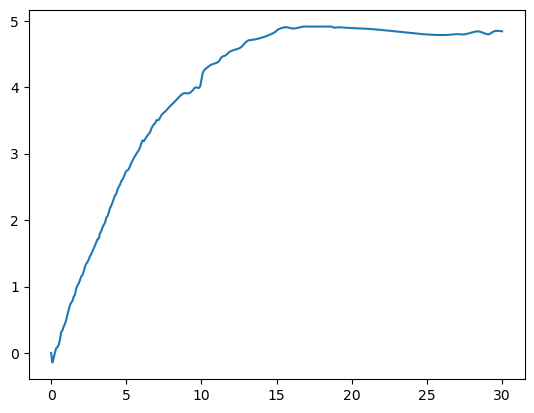

In [12]:
plt.plot(zero_curve_df.loc['2010-01-01', 'Maturities'], zero_curve_df.loc['2010-01-01','Curve'])

In [13]:
# Filter to get regular maturities intervals to compute smooth par corve
zero_curve_filt = zero_curve_df.loc[zero_curve_df['Maturities'] % 0.5 == 0]

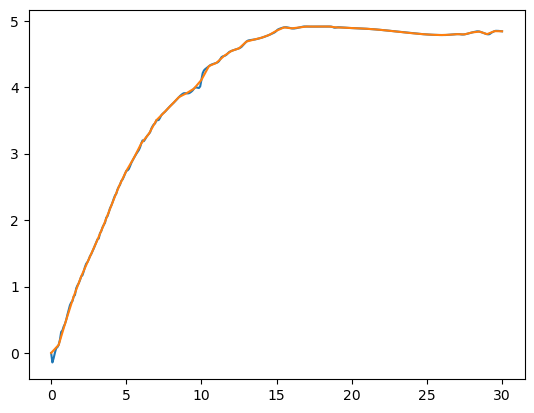

In [14]:
plt.plot(zero_curve_df.loc['2010-01-01', 'Maturities'], zero_curve_df.loc['2010-01-01','Curve'])
plt.plot(zero_curve_filt.loc['2010-01-01', 'Maturities'], zero_curve_filt.loc['2010-01-01','Curve'])

# Convert Spot Curve into Par Curve

In [15]:
# Return zero coupon yield for given maturity
def zero_curve_func(date, maturity, dataset):
    curve = dataset.loc[date]
    maturities = curve['Maturities'].values
    yields = curve['Curve'].values

    spline = CubicSpline(maturities, yields, bc_type='natural')

    return spline(maturity)

In [16]:
# Computes the difference between the bond's present value and its par value.
def par_bond_equation(c, tenor, r):

    discounted_cash_flows = sum(
        (c / 2) * np.exp(-(r / 100) * t)
        for t in np.arange(0.5, tenor + 0.5, 0.5)
    )

    final_payment = 100 * np.exp((-r / 100) * tenor)

    return discounted_cash_flows + final_payment - 100

# Compute par curve for a given date
def par_curve_func(date, dataset):
    maturities = dataset.loc[date, 'Maturities'].unique()
    par_yields = []

    for maturity in maturities:
        tenor = maturity
        r = zero_curve_func(date, tenor, dataset)
        try:
            lower_bound, upper_bound = 0, 12

            par_yield = brentq(
                par_bond_equation,
                a=lower_bound,
                b=upper_bound,
                args=(tenor, r))
            par_yields.append({'Maturities': maturity, 'Par Curve': par_yield})

        except ValueError as e:
            #print(f"Error for date {date}, maturity {maturity}: {e}")
            continue

    return pd.DataFrame(par_yields)

# Compute the par yield curves for all unique dates in the dataset.
def compute_par_curves(dataset):

    results = []

    for date in tqdm(dataset.index.unique()):
        par_curve = par_curve_func(date, dataset)
        par_curve['Date'] = date
        results.append(par_curve)

    # Concatenate all results into a single DataFrame
    par_curve_df = pd.concat(results, ignore_index=True)
    par_curve_df.set_index(['Date'], inplace=True)
    return par_curve_df


In [17]:
par_curve_df = compute_par_curves(zero_curve_filt)

100%|██████████| 3873/3873 [01:14<00:00, 51.75it/s]


### par and spot curve comparison, par curve is higher than spot curve - does not make much sense, to be revised

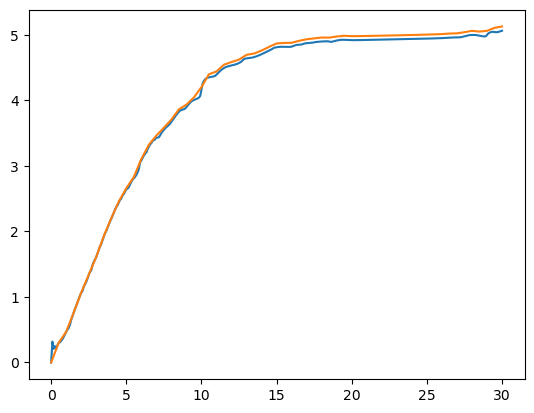

In [18]:
plt.plot(zero_curve_df.loc['2010-04-01', 'Maturities'], zero_curve_df.loc['2010-04-01','Curve'])
plt.plot(par_curve_df.loc['2010-04-01', 'Maturities'], par_curve_df.loc['2010-04-01','Par Curve'])

# Nelson-Siegel Model

In [19]:
def nelson_siegel(params, maturities):
    beta0, beta1, beta2, lambd = params

    # set a min value for lambda to account for 0 division in optimization problems
    lambd = max(lambd, 1e-6)

    t = maturities

    alpha_1 = (1 - np.exp(-t/lambd))/(t/lambd)
    alpha_2 = (1 - np.exp(-t/lambd))/(t/lambd) - np.exp(-t/lambd)
    return beta0 + beta1 * alpha_1 + beta2 * alpha_2

In [20]:
# Error function to minimize to find optimal params
def error_function(params, maturities, data):
    data_hat = nelson_siegel(params, maturities)
    return np.sum((data - data_hat) ** 2)

# We define ridge error function as
def ridge_error_function(params, maturities, data, alpha=0.1):
    data_hat = nelson_siegel(params, maturities)
    error = np.sum((data - data_hat) ** 2)
    regularization = alpha * (params[0]**2 + params[1]**2 + params[2]**2 + params[3]**2)
    return error + regularization

In [21]:
def apply_nelson_siegel(df, ridge = False, alpha = 0.1):

    # Store results in a DataFrame
    fitted_results = []

    initial_params = [0.01, 0.01, 0.01, 1]

    for date in tqdm(df.index.get_level_values(0).unique()):
        par_curve = df.loc[date]
        current_yields = par_curve['Curve']
        current_maturities = par_curve['Maturities']

        if ridge == False:
            result = minimize(
                    error_function,
                    initial_params,
                    args=(current_maturities, current_yields),
                    method="L-BFGS-B",
                    options={'maxiter': 1000},
                )

        if ridge == True:
            result = minimize(
                    ridge_error_function,
                    initial_params,
                    args=(current_maturities, current_yields, alpha),
                    method="L-BFGS-B",
                    options={'maxiter': 1000},
                )

        params = result.x

        # Store results for the current date
        fitted_results.append({
            "Date": date,
            "Beta0 (Level)": params[0],
            "Beta1 (Slope)": params[1],
            "Beta2 (Curvature)": params[2],
            "Lambda": params[3],
        })


    # Convert results to a DataFrame
    fitted_results_df = pd.DataFrame(fitted_results)
    fitted_results_df.set_index('Date', inplace=True)

    return fitted_results_df

## Apply Nelson Siegel to Spot Curve

In [22]:
loadings_df = apply_nelson_siegel(zero_curve_df)

  0%|          | 0/3873 [00:00<?, ?it/s]


KeyError: 'Par Curve'

In [164]:
loadings_df.head()

,Beta0 (Level),Beta1 (Slope),Beta2 (Curvature),Lambda
Date,,,,
2010-01-01,5.597323,-5.249010,-6.708946,1.198430
2010-01-04,5.643518,-5.178211,-7.190116,1.201034
2010-01-05,5.628347,-5.169322,-7.252576,1.224219
2010-01-06,5.736166,-5.285048,-7.437311,1.227354
2010-01-07,5.723462,-5.320545,-7.201473,1.238189


In [165]:
loadings_df_ridge = apply_nelson_siegel(zero_curve_df, ridge = True)

100%|██████████| 3873/3873 [03:50<00:00, 16.78it/s]


In [166]:
loadings_df_ridge.head()

,Beta0 (Level),Beta1 (Slope),Beta2 (Curvature),Lambda
Date,,,,
2010-01-01,5.572694,-6.010503,-1.983840,1.850009
2010-01-04,5.621220,-6.065138,-2.133244,1.877268
2010-01-05,5.605433,-6.068150,-2.195220,1.906138
2010-01-06,5.714848,-6.212756,-2.219824,1.922273
2010-01-07,5.701292,-6.185791,-2.152239,1.927749


# Returns

## Gross Returns

In [237]:
# Function to compute returns
def compute_gross_returns(df):
    # Calculate daily coupons (coupon/365) and lagged price
    df.loc[:, 'daily_coupons'] = df['coupon'] / 365
    df.loc[:, 'prev_price'] = df.groupby('id')['price'].shift(1)  # Lagged price for each bond

    # Compute returns using the formula
    df.loc[:, 'returns'] = ((df['price'] + df['daily_coupons']) - df['prev_price']) / df['prev_price']

    return df

In [238]:
data = compute_gross_returns(data)

## Carry

In [239]:
def compute_carry(df):
    df['carry'] = df['daily_coupons'] / df['prev_price']
    return df

In [240]:
data = compute_carry(data)

## Rolldown

In [224]:
# price a bond
def price_bond(spot_curve_handle, coupon, issue_date, maturity_date):

    # Bond params
    calendar = ql.UnitedStates(m=ql.UnitedStates.GovernmentBond)
    day_count = ql.ActualActual(ql.ActualActual.ISDA)
    issue_date = pydatetime_to_quantlib_date(issue_date)
    maturity_date = pydatetime_to_quantlib_date(maturity_date)
    tenor = ql.Period(ql.Semiannual)
    business_convention = ql.Unadjusted
    date_generation = ql.DateGeneration.Backward
    month_end = False

    schedule = ql.Schedule(issue_date,
                           maturity_date,
                           tenor,
                           calendar,
                           business_convention,
                           business_convention,
                           date_generation,
                           month_end)

    coupon_rate = [coupon/100]
    settlement_days = 1
    face_value = 100

    fixed_rate_bond = ql.FixedRateBond(settlement_days,
                                       face_value,
                                       schedule,
                                       coupon_rate,
                                       day_count)

    bond_engine = ql.DiscountingBondEngine(spot_curve_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)

    return fixed_rate_bond.cleanPrice()

In [227]:
def compute_rolldown(df, on_the_run_bonds):
    # Create an empty series to store roll-down results
    df.loc[:, 'rolldown'] = np.nan


    for i, date in enumerate(tqdm(on_the_run_bonds.index.get_level_values(0).unique())):

        curve_set_df = on_the_run_bonds.loc[date]  # Curve at t-1

        # Spot Curve
        yc = get_spot_rates_bootstrapper(curve_set_df, date, rolldown=True)
        spot_curve_handle = ql.YieldTermStructureHandle(yc)

        # Move froward by one day to compute roll-down if term structure is constant
        if i + 1 < len(on_the_run_bonds.index.get_level_values(0).unique()):
            current_date = on_the_run_bonds.index.get_level_values(0).unique()[i + 1]

        else:
            break

        for id in df.loc[current_date].index:
            bond_id = id
            coupon = df.loc[current_date, id]['coupon']
            issue_date = df.loc[current_date, id]['issue_date']
            maturity_date = df.loc[current_date, id]['maturity_date']

            # price at t-1
            try:
                # Safely attempt to get price_t1
                price_t1 = df.loc[date, bond_id]['price']

                # Price at t
                price_t = price_bond(spot_curve_handle, coupon, issue_date, maturity_date)

                # Compute roll-down
                roll_down = price_t / price_t1 - 1

            except (KeyError, IndexError, ValueError) as e:
                # Handle errors from .loc or other computations
                roll_down = np.nan

            # Store the result in the roll_down_series
            df.at[(current_date, bond_id), 'rolldown'] = roll_down

    return df

In [228]:
data = compute_rolldown(data)

100%|█████████▉| 3872/3873 [07:26<00:00,  8.67it/s]


## Excess Returns

In [244]:
data['Excess Returns'] = data['returns'] - data['carry'] - data['rolldown']

# Cross-Sectional Regression

In [261]:
def cross_sectional_regression(df, loadings_df):
        results = []
        for date in tqdm(df.index.get_level_values(0).unique()):
            ex = df.loc[date].dropna()

            if len(ex) == 0:
                continue

            lambda_ = loadings_df.loc[date, 'Lambda']

            t = ex['time to maturity']

            ex['f1'] = (1 - np.exp(-t/lambda_))/(t/lambda_)
            ex['f2'] = (1 - np.exp(-t/lambda_))/(t/lambda_) - np.exp(-t/lambda_)

            y = ex['Excess Returns']
            X = sm.add_constant(ex[['f1', 'f2']])

            model = sm.OLS(y, X).fit()


            results.append({
                'date': date,
                'const': model.params.get('const', np.nan),
                'beta1': model.params.get('f1', np.nan),
                'beta2': model.params.get('f2', np.nan),
                'r_squared': model.rsquared
                })
        # Convert results into a DataFrame
        results_df = pd.DataFrame(results)

        return results_df

In [1]:
on_the_run_bonds

NameError: name 'on_the_run_bonds' is not defined